# Imports & Setup

In [14]:
# Imports & Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier


In [15]:
plt.rcParams['figure.figsize'] = (10,5)


# Load Data

In [17]:
trades = pd.read_csv('/content/trades.csv')
print(trades)

         pair      amount      volume  side                    timestamp  \
0     AAVENGN    500.2600    0.001222   buy  2024-12-03T01:42:07.072672Z   
1      ADANGN    889.2000    0.500000  sell  2024-12-02T11:29:56.860014Z   
2      ADANGN  30653.1200   17.100000  sell   2024-11-30T05:25:49.99166Z   
3      ADANGN   1978.3600    1.100000  sell  2024-12-07T07:41:02.191598Z   
4      ADANGN   2913.6200    1.600000  sell  2024-12-07T21:16:11.791118Z   
...       ...         ...         ...   ...                          ...   
2319   XRPNGN   6922.2700    1.900000  sell  2024-12-09T11:50:37.124743Z   
2320  XRPUSDT    537.0800  200.000000  sell  2024-12-03T04:31:23.716954Z   
2321  XRPUSDT    998.9047  426.700000   buy  2024-12-02T11:23:13.522375Z   
2322  XRPUSDT    970.2390  361.800000  sell  2024-12-03T03:12:59.282381Z   
2323  XRPUSDT   1007.3632  362.400000   buy  2024-12-03T04:16:44.954974Z   

                       user_id  
0       541-1561-1521-1561-148  
1       491-1541-1521

In [19]:
user_activity = pd.read_csv('/content/user_activitycsv.csv')
print(user_activity)

     asset    amount activity_type                    timestamp  \
0      NGN  131062.0    withdrawal  2025-01-17T14:37:56.806446Z   
1      NGN   50000.0    withdrawal  2025-01-17T14:37:56.818033Z   
2      NGN  131062.0       deposit  2025-01-17T14:37:56.853225Z   
3      NGN   20064.0    withdrawal  2025-01-17T17:05:18.201218Z   
4      NGN    2000.0    withdrawal  2025-01-17T14:38:22.555744Z   
...    ...       ...           ...                          ...   
4840   NGN    5100.0    withdrawal  2025-01-18T13:07:55.119388Z   
4841   NGN  146860.0       deposit   2025-03-12T17:55:24.70215Z   
4842   NGN  100000.0    withdrawal  2025-03-12T21:58:33.931876Z   
4843   NGN   20000.0    withdrawal  2025-01-18T13:08:05.009124Z   
4844   NGN   15000.0    withdrawal  2025-01-18T13:08:26.555119Z   

                       user_id  
0      561-1561-1521-1981-1101  
1     971-11001-1521-1571-1101  
2     481-11011-1521-1971-1100  
3      531-11001-1521-1571-198  
4      501-11021-1521-1561-154

In [20]:
# Convert timestamps
trades['timestamp'] = pd.to_datetime(trades['timestamp'])
user_activity['timestamp'] = pd.to_datetime(user_activity['timestamp'])

EXPLORATORY DATA ANALYSIS

In [21]:
# 1. Market Dynamics
# Convert all quote currencies to USD using fixed rate
USD_RATE = 1500

trades['price'] = trades['amount'] / trades['volume']
trades['usd_volume'] = trades['price'] * trades['volume'] / USD_RATE

pair_volume = (
    trades.groupby('pair')['usd_volume']
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

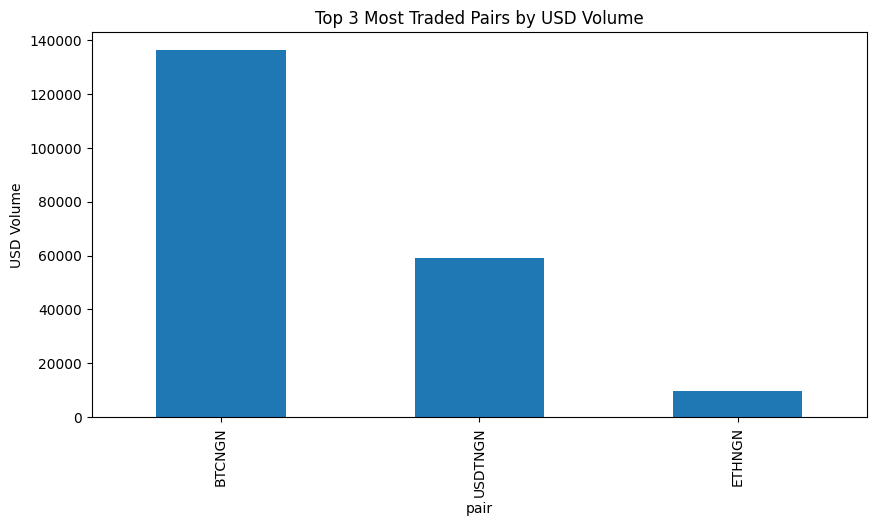

In [22]:
pair_volume.plot(kind='bar', title='Top 3 Most Traded Pairs by USD Volume')
plt.ylabel('USD Volume')
plt.show()


In [23]:
# 2. Volatility Analysis (BTCNGN)
btc = trades[trades['pair'] == 'BTCNGN'].copy()
btc['date'] = btc['timestamp'].dt.date


In [24]:
# Daily volatility = std of prices per day
daily_vol = btc.groupby('date')['price'].std()
rolling_vol = daily_vol.rolling(7).mean()


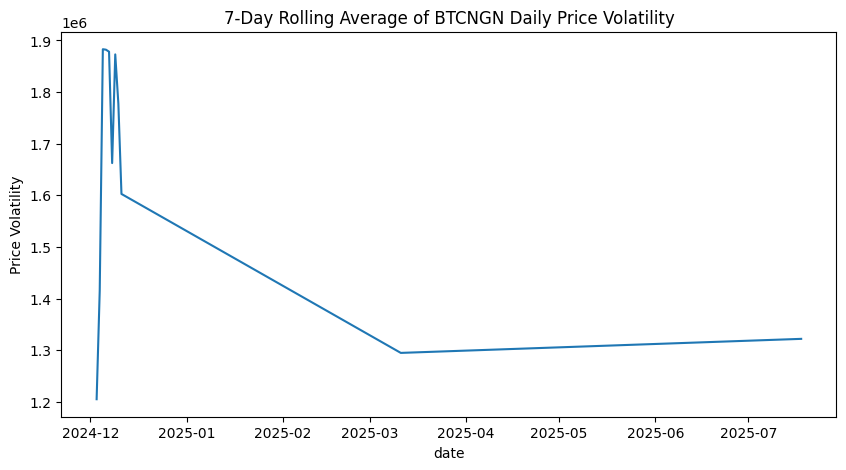

In [25]:
rolling_vol.plot(title='7-Day Rolling Average of BTCNGN Daily Price Volatility')
plt.ylabel('Price Volatility')
plt.show()

In [26]:
# 3. User Behavior: Deposits by Time
deposits = user_activity[user_activity['activity_type'] == 'deposit'].copy()
deposits['day_of_week'] = deposits['timestamp'].dt.day_name()
deposits['hour'] = deposits['timestamp'].dt.hour

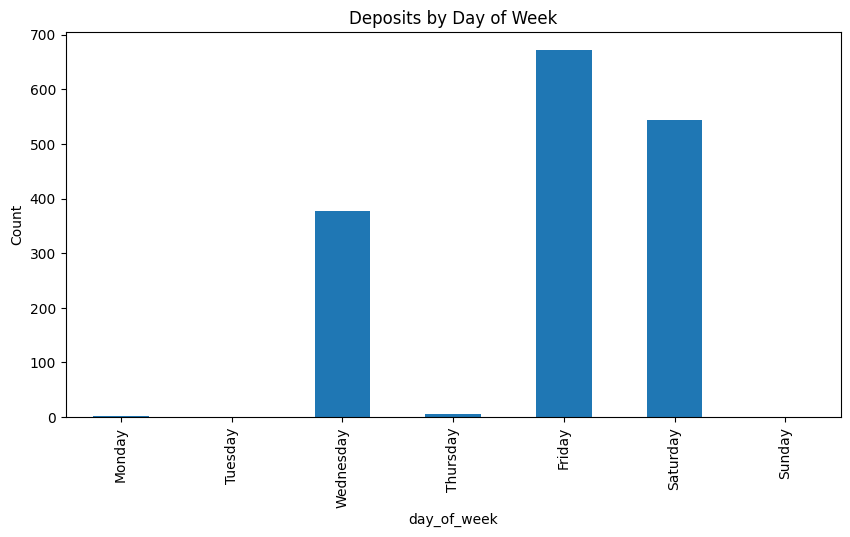

In [27]:
# By day
deposits.groupby('day_of_week').size().reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
]).plot(kind='bar', title='Deposits by Day of Week')
plt.ylabel('Count')
plt.show()

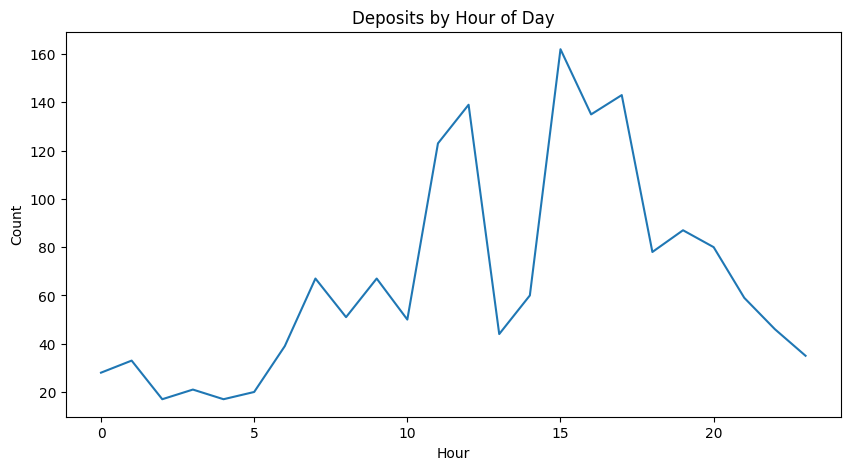

In [28]:
# By hour
deposits.groupby('hour').size().plot(title='Deposits by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

Part 2: Fraud Detection Model

# Problem Context
A common fraudulent pattern on trading platforms involves users who deposit funds, perform little to no trading activity, and quickly withdraw their funds. The objective here is to identify users exhibiting this behavior using a combination of rule-based labeling and supervised machine learning.




In [29]:
# Feature Engineering

# Deposit & withdrawal counts
activity_counts = user_activity.pivot_table(
    index='user_id',
    columns='activity_type',
    values='timestamp',
    aggfunc='count'
).fillna(0)

In [30]:
# First deposit and withdrawal times
first_events = user_activity.sort_values('timestamp').groupby(['user_id','activity_type']).first().unstack()
first_events.columns = ['_'.join(col).strip() for col in first_events.columns.values]
features = activity_counts.join(first_events)

In [31]:
# Time between first deposit and withdrawal (in hours)
features['time_to_withdraw_hrs'] = (
    features['timestamp_withdrawal'] - features['timestamp_deposit']
).dt.total_seconds() / 3600

In [32]:
# Trading volume per user
trade_volume = trades.groupby('user_id')['usd_volume'].sum()
features = features.join(trade_volume.rename('total_trade_usd')).fillna(0)

In [33]:
# Unique assets traded
features['unique_pairs'] = trades.groupby('user_id')['pair'].nunique()
features['unique_pairs'] = features['unique_pairs'].fillna(0)

In [34]:
# Rule-Based Labeling
# Suspicious if:
# - Has deposits and withdrawals
# - Withdraws within 24 hours
# - Very low trading volume
features['suspicious'] = (
    (features['deposit'] > 0) &
    (features['withdrawal'] > 0) &
    (features['time_to_withdraw_hrs'] <= 24) &
    (features['total_trade_usd'] < features['deposit'] * 50)
).astype(int)


In [35]:
# Model Building ---
X = features[[
    'deposit',
    'withdrawal',
    'time_to_withdraw_hrs',
    'total_trade_usd',
    'unique_pairs'
]].fillna(0)


In [36]:

y = features['suspicious']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [38]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [39]:
y_pred = model.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       257
           1       0.98      0.96      0.97       103

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

Precision: 0.9801980198019802
Recall: 0.9611650485436893


# Part 3: Strategic Recommendation


#Part 3: Strategic Recommendation – Low-Volume Trader Campaign (Kenya)

# Business Objective
The product team plans to launch a marketing campaign targeted at *Low-Volume Traders* in Kenya. The aim is to increase engagement and trading activity among users who are active but trade in relatively small amounts.

# Defining the Target Audience
Using insights from the data, the target audience can be defined using the following data-driven criteria:

1. **Low Average Trading Volume**  
   Users whose total or average monthly trading volume falls below a defined threshold (e.g., bottom 30–40% of traders by USD volume). These users are active but not deeply engaged in trading.

2. **High Deposit-to-Trade Ratio**  
   Users who deposit funds but convert only a small portion into executed trades. This indicates hesitation, lack of confidence, or unmet education needs.

3. **Consistent Platform Activity**  
   Users who log deposits or trades regularly (e.g., at least once per month), showing retained interest even if trade sizes are small.

# Rationale
Targeting this segment allows the business to:
- Increase overall trading volume with minimal acquisition cost
- Educate users and reduce friction to trade
- Convert passive users into active traders through incentives, tutorials, or fee discounts

This strategy balances growth and retention while leveraging existing user behavior patterns.